In [1]:
### Problem Definition

### Predicting the ride duration of taxi trips in New York. Given various features like pickup datetime, dropoff date time
### passenger count, vendor id, pick up latitude and longitude, dropoff latitude and longitude, predict the duration of the trip

In [2]:
### Loading the necessary libraries 

In [3]:
pip install geopy

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [5]:
### Data Extraction

### Collect data required for the project from the CSV file that contains information regarding the starting and ending 
### of a trip, geographic information, passenger count, trip duration, etc.

In [6]:
trip_dur = pd.read_csv("nyc_taxi_trip_duration.csv")

In [7]:
### To see how the data frame looks like, let us use the head function
trip_dur.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [8]:
### Let us count the number of rows and columns in the data frame using shape function
trip_dur.shape

(729322, 11)

In [9]:
### We can see that our data frame has 729322 rows and 11 columns

In [10]:
### Now let us check the different columns/features in our data frame together with the data type
trip_dur.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [11]:
### Data Transformation

In [12]:
### Let us check for null values if any. If null values are found, we need to replace them
trip_dur.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [13]:
### We can see that there are no null values in the given data set

In [14]:
### We can see that the pick up and drop off columns in our data frame is of object type
### We need to convert it to datetime format
### Similarly store_and_forward_flag can be converted to boolean type

trip_dur['pickup_datetime'] = pd.to_datetime(trip_dur.pickup_datetime)
trip_dur['dropoff_datetime'] = pd.to_datetime(trip_dur.dropoff_datetime)
trip_dur['store_and_fwd_flag'] = 1 * (trip_dur.store_and_fwd_flag.values == 'Y')

In [15]:
trip_dur.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int32
trip_duration                  int64
dtype: object

In [16]:
### Our target is trip duration, let us try to explore more on that
trip_dur['trip_duration'].describe()/3600

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

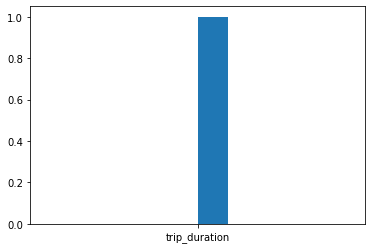

In [17]:
### Let us try to visualize the trip duration using a histogram
plt.hist('trip_duration')
plt.show()

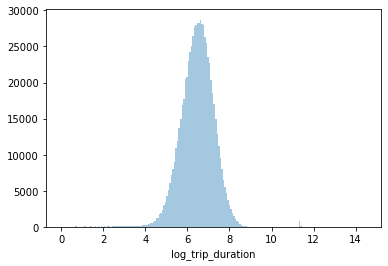

In [18]:
### We can see that the visualization is not good and points are close by
### Hence, it is a better idea to use log transformation and then plot the histogram
trip_dur['log_trip_duration'] = np.log(trip_dur['trip_duration'].values)
sns.distplot(trip_dur['log_trip_duration'], kde = False, bins = 200)
plt.show()

In [19]:
### The majority of rides follow a rather smooth distribution that looks almost log-normal 
### Peak is around exp(6.5) i.e. about 17 minutes.
### There are a few outliers near exp(12).

In [20]:
### Now that we have looked at the target variable, let us look into the feature variables one by one. 
### This is called univariate analysis

In [21]:
### Univariate Analysis on individual features
### First of all, let us look at some of the binary/discrete features. 
### The discrete features in the data set includes vendor_id, passenger_count
### Binary features in the dataset include store_and_forward_flag

In [22]:
### Let us start the analysis by looking into the plot of discrete variable counts

Text(0, 0.5, 'Frequency')

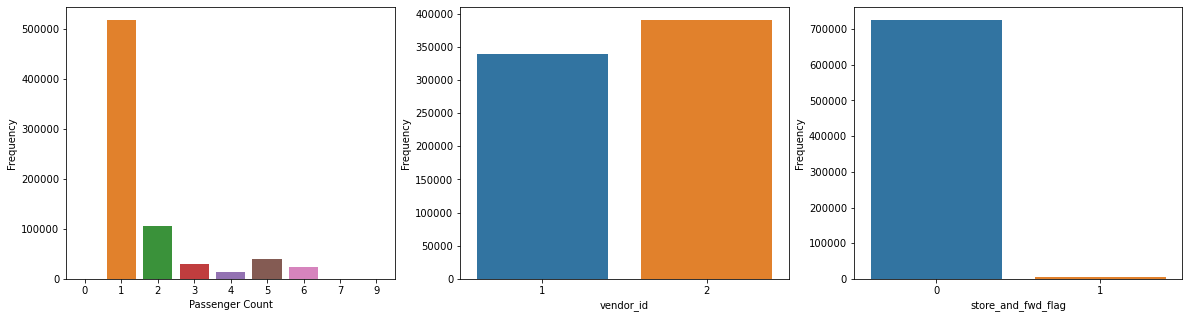

In [23]:
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
sns.countplot(trip_dur['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.subplot(1,3,2)
sns.countplot(trip_dur['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')
plt.subplot(1,3,3)
sns.countplot(trip_dur['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')

In [24]:
### Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
### Vendor 2 has more number of trips as compared to vendor 1
### The store_and_fwd_flag values show that there was almost no storing taking place

In [25]:
### Let us now consider the univariate analysis of certain numeric variables like pick up & drop off latitude and longitude 

In [26]:
### Let us check the box plots of pickup latitudes and longitudes, drop off longitudes and longitudes

<AxesSubplot:xlabel='dropoff_longitude'>

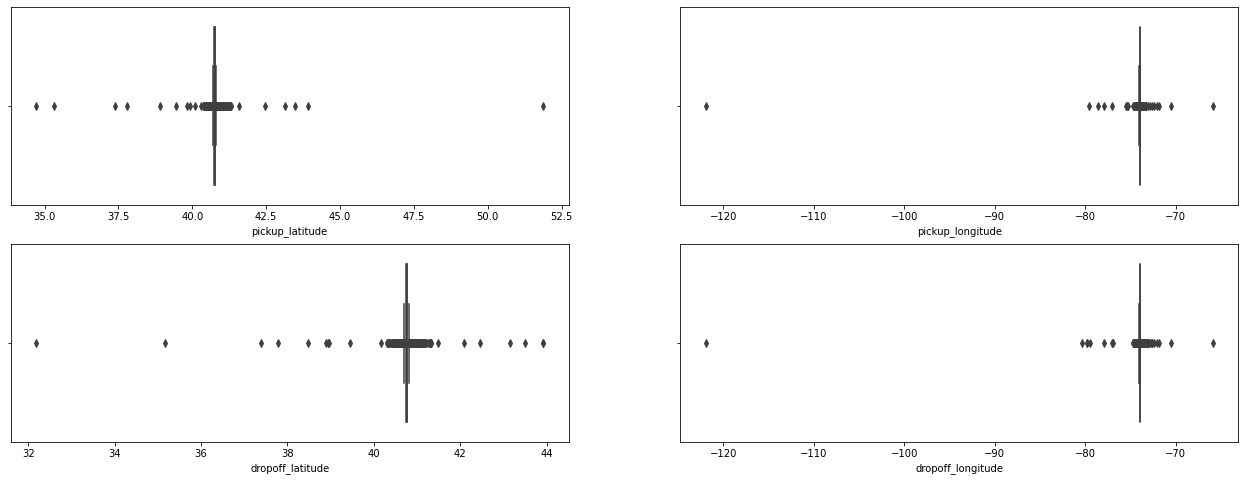

In [27]:
plt.figure(figsize=(22, 8))
plt.subplot(2,2,1)
sns.boxplot(trip_dur['pickup_latitude'])
plt.subplot(2,2,2)
sns.boxplot(trip_dur['pickup_longitude'])
plt.subplot(2,2,3)
sns.boxplot(trip_dur['dropoff_latitude'])
plt.subplot(2,2,4)
sns.boxplot(trip_dur['dropoff_longitude'])

In [28]:
### From the plot above it is clear that pick and drop latitude are centered around 40 to 41, 
### and longitude are situated around -74 to -73
### A good idea is to remove these outliers and look at the distribution more closely

In [29]:
upper_lim1 = np.percentile(trip_dur['pickup_latitude'],75,interpolation = 'midpoint')
lower_lim1 = np.percentile(trip_dur['pickup_latitude'],25,interpolation = 'midpoint')
IQR1 = upper_lim1 - lower_lim1
upper1 = (upper_lim1+1.5*IQR1)
lower1 = (lower_lim1-1.5*IQR1)

upper_lim2 = np.percentile(trip_dur['pickup_longitude'],75,interpolation = 'midpoint')
lower_lim2 = np.percentile(trip_dur['pickup_longitude'],25,interpolation = 'midpoint')
IQR2 = upper_lim2 - lower_lim2
upper2 = (upper_lim2+1.5*IQR2)
lower2 = (lower_lim2-1.5*IQR2)

upper_lim3 = np.percentile(trip_dur['dropoff_latitude'],75,interpolation = 'midpoint')
lower_lim3 = np.percentile(trip_dur['dropoff_latitude'],25,interpolation = 'midpoint')
IQR3 = upper_lim3 - lower_lim3
upper3 = (upper_lim3+1.5*IQR3)
lower3 = (lower_lim3-1.5*IQR3)

upper_lim4 = np.percentile(trip_dur['dropoff_longitude'],75,interpolation = 'midpoint')
lower_lim4 = np.percentile(trip_dur['dropoff_longitude'],25,interpolation = 'midpoint')
IQR4 = upper_lim4 - lower_lim4
upper4 = (upper_lim4+1.5*IQR4)
lower4 = (lower_lim4-1.5*IQR4)

trip_dur_no_outliers = trip_dur[(trip_dur['pickup_latitude'] < upper1) & (trip_dur['pickup_latitude'] > lower1)]
trip_dur_no_outliers = trip_dur_no_outliers[(trip_dur_no_outliers['pickup_longitude'] < upper2) & (trip_dur_no_outliers['pickup_longitude'] > lower2)]
trip_dur_no_outliers = trip_dur_no_outliers[(trip_dur_no_outliers['dropoff_latitude'] < upper3) & (trip_dur_no_outliers['dropoff_latitude'] > lower3)]
trip_dur_new = trip_dur_no_outliers[(trip_dur_no_outliers['dropoff_longitude'] < upper4) & (trip_dur_no_outliers['dropoff_longitude'] > lower4)]

In [30]:
### Let us check again the distribution of pickup latitudes and longitudes, drop off longitudes and longitudes
### The potential outliers are removed and the box plot looks much better now
### This shows how significant it is to remove outliers during analysis

<AxesSubplot:xlabel='dropoff_longitude'>

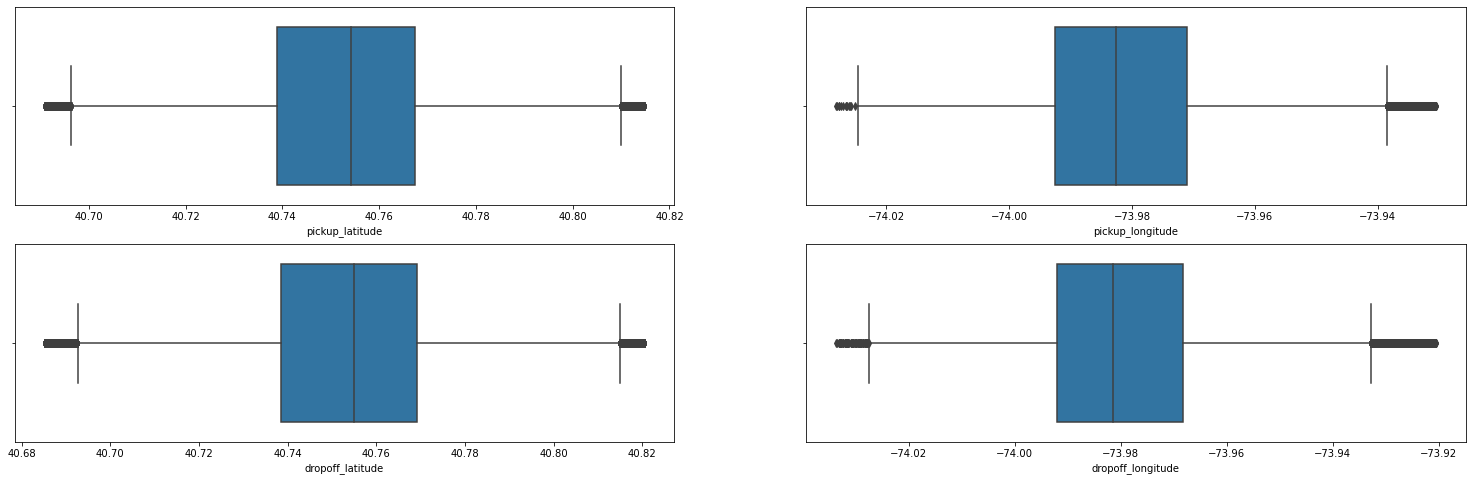

In [31]:
plt.figure(figsize=(26, 8))
plt.subplot(2,2,1)
sns.boxplot(trip_dur_new['pickup_latitude'])
plt.subplot(2,2,2)
sns.boxplot(trip_dur_new['pickup_longitude'])
plt.subplot(2,2,3)
sns.boxplot(trip_dur_new['dropoff_latitude'])
plt.subplot(2,2,4)
sns.boxplot(trip_dur_new['dropoff_longitude'])

In [32]:
### Let us also perform a univariate analysis by performing a count plot on the distribution of trips 
### over days in a week and time in a day
### Let us now try to understand how the number of trips vary during different days of a week
### Also, which hour of a day has the highest number of trips

Text(0, 0.5, 'Total number of Trips')

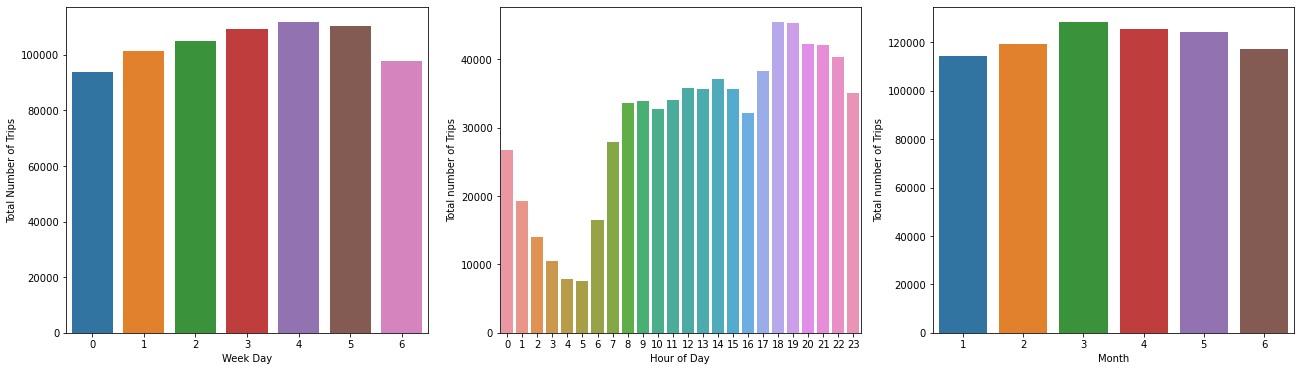

In [33]:
trip_dur['day_of_week'] = trip_dur['pickup_datetime'].dt.weekday
trip_dur['hour_of_day'] = trip_dur['pickup_datetime'].dt.hour
trip_dur['month'] = trip_dur['pickup_datetime'].dt.month

plt.figure(figsize=(22, 6))

# Distribution of number of trips over days of a week

plt.subplot(1,3,1)
sns.countplot(trip_dur['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of Trips')

# Distribution of number of trips over hours of a day

plt.subplot(1,3,2)
sns.countplot(trip_dur['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of Trips')

# Distribution of number of trips over hours of a day

plt.subplot(1,3,3)
sns.countplot(trip_dur['month'])
plt.xlabel('Month')
plt.ylabel('Total number of Trips')

In [34]:
### Number of pickups for weekends is much lower than week days with a peak on Thursday (4)
### Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
### The analysis is considering a 6 month period and the number of trips vary slightly over the months, with maximum during month 3

In [35]:
### Now that we have looked at univariate analysis of single features, 
### let us move forward to bivariate analysis between each of the features and between features and target variable

In [36]:
### Let us first look at the correlation matrix

In [37]:
correlation = trip_dur.dropna().corr()
correlation

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_week,hour_of_day,month
vendor_id,1.000000,0.286463,0.008198,0.002861,0.002371,0.005259,-0.080120,0.027752,0.019543,0.000787,0.009772,-0.005363
passenger_count,0.286463,1.000000,0.001163,-0.004696,-0.000027,-0.003944,-0.020898,0.013022,0.020824,0.025758,0.009851,-0.001481
pickup_longitude,0.008198,0.001163,1.000000,0.047635,0.780647,0.118473,0.011732,0.035447,0.111642,-0.016031,0.010754,0.004037
pickup_latitude,0.002861,-0.004696,0.047635,1.000000,0.119970,0.479352,-0.009230,-0.038163,-0.141892,-0.029073,0.011433,-0.000165
dropoff_longitude,0.002371,-0.000027,0.780647,0.119970,1.000000,0.149598,0.009801,0.020664,0.072442,-0.001473,-0.022014,0.003883
dropoff_latitude,0.005259,-0.003944,0.118473,0.479352,0.149598,1.000000,-0.011415,-0.028283,-0.124394,-0.022028,0.014257,-0.000580
store_and_fwd_flag,-0.080120,-0.020898,0.011732,-0.009230,0.009801,-0.011415,1.000000,0.002754,0.016271,-0.001940,0.002036,0.000238
trip_duration,0.027752,0.013022,0.035447,-0.038163,0.020664,-0.028283,0.002754,1.000000,0.326479,-0.002302,0.002979,0.009378
log_trip_duration,0.019543,0.020824,0.111642,-0.141892,0.072442,-0.124394,0.016271,0.326479,1.000000,-0.028373,0.038870,0.047155
day_of_week,0.000787,0.025758,-0.016031,-0.029073,-0.001473,-0.022028,-0.001940,-0.002302,-0.028373,1.000000,-0.082079,-0.013626


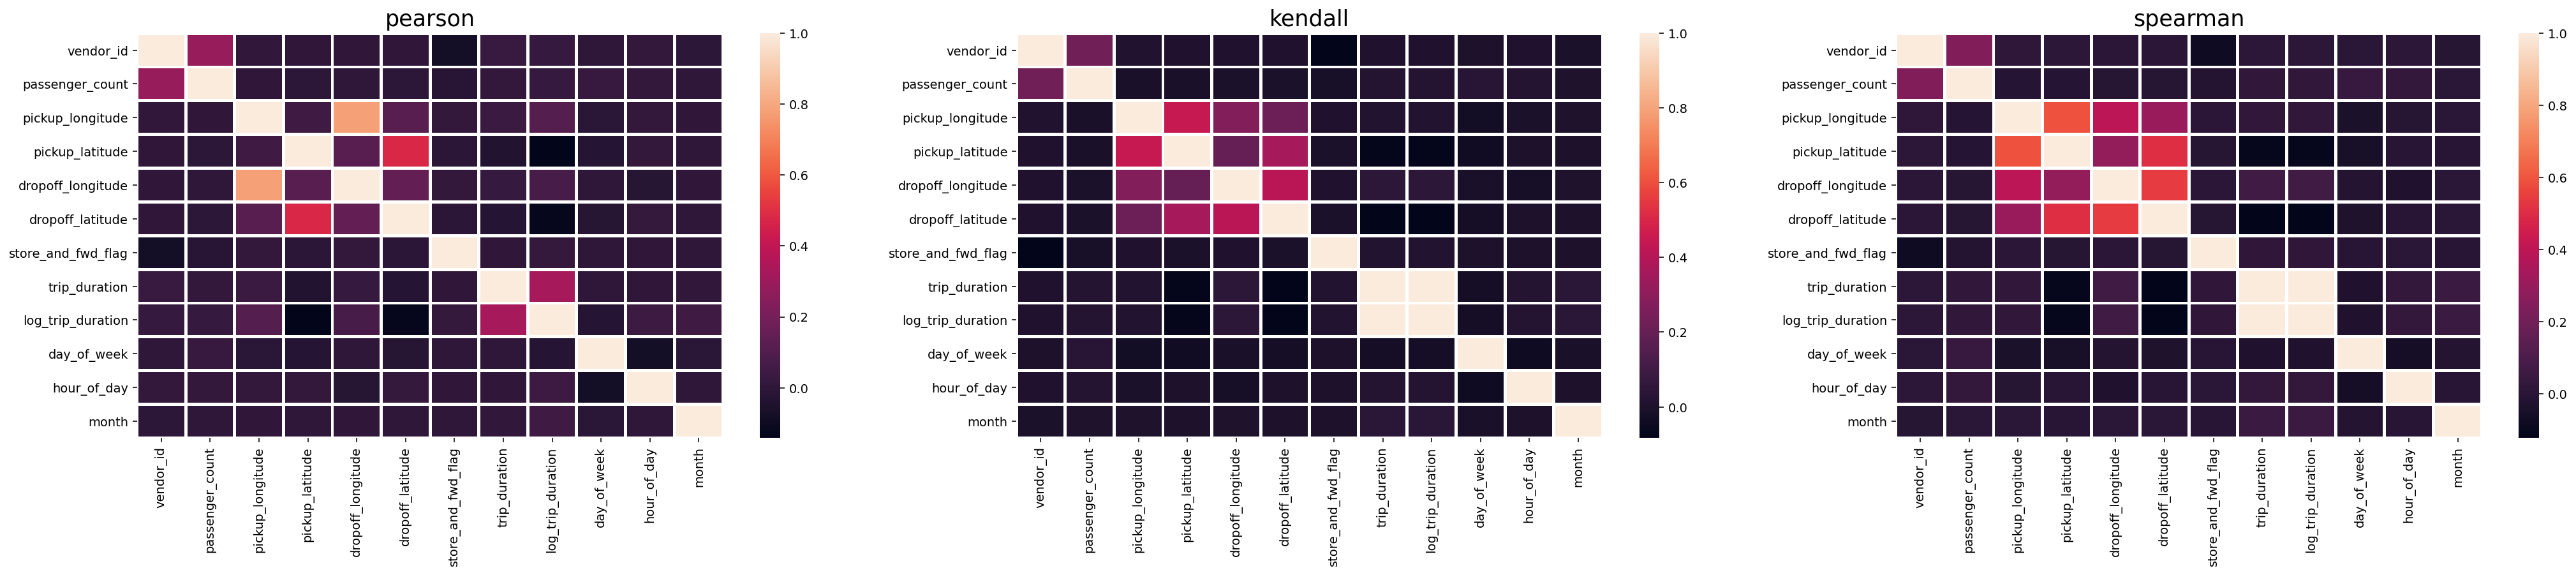

In [38]:
# plotting heatmap usill all methods for all numerical variables
plt.figure(figsize=(36,6), dpi=140)
for j,i in enumerate(['pearson','kendall','spearman']):
  plt.subplot(1,3,j+1)
  correlation = trip_dur.dropna().corr(method=i)
  sns.heatmap(correlation, linewidth = 2)
  plt.title(i, fontsize=18)

In [39]:
### Pearson, Kendall and Spearman correlation seem to have very similar pattern between them, 
### except variations in magnitude of correlation.
### Too many variables with insignificant correlation indicated in black
### Major correlation lies between the pickup and dropoff latitude and longitudes 

In [40]:
### Hypothesis that need to be tested

In [41]:
### Before we perform hypothesis testing, let us define two functions to perform z-test and t-test

In [42]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
  from numpy import sqrt, abs, round
  from scipy.stats import norm
  ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
  z = (X1 - X2)/ovr_sigma
  pval = 2*(1 - norm.cdf(abs(z)))
  return pval

In [43]:
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
  from numpy import sqrt, abs, round
  from scipy.stats import t as t_dist
  ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
  t = (X1 - X2)/ovr_sd
  df = n1+n2-2
  pval = 2*(1 - t_dist.cdf(abs(t),df))
  return pval

In [44]:
def Bivariate_cont_cat(data, cont, cat, category):
  #creating 2 samples
  x1 = data[cont][data[cat]==category][:]
  x2 = data[cont][~(data[cat]==category)][:]
  
  #calculating descriptives
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.std()
  
  #calculating p-values
  t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
  z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

  #table
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

  #plotting
  plt.figure(figsize = (15,6), dpi=140)
  
  #barplot
  plt.subplot(1,2,1)
  sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                z_p_val,
                                                                table))

  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=cat, y=cont, data=data)
  plt.title('categorical boxplot')

In [45]:
### Hypothesis 1:-Is the average speed of journey more in vendor 1 compared to vendor 2?

In [46]:
### For this we need to first find distance using geopy library

In [47]:
def distance_trip(pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude):
    start_coordinates = (pickup_latitude,pickup_longitude)
    stop_coordinates = (dropoff_latitude,dropoff_longitude)
    return great_circle(start_coordinates,stop_coordinates).km

In [48]:
### Now, let us crate a distance feature to our trip_dur dataframe using the lambda function

In [49]:
trip_dur['distance'] = trip_dur.apply(lambda x: distance_trip(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis=1)

In [50]:
### Let us create one more feature called average speed

In [51]:
trip_dur['average_speed'] = trip_dur['distance']/(trip_dur['trip_duration']/3600)

In [52]:
### Now let us go forward with the first hypothesis: Is the average speed of journey more in vendor 1 compared to vendor 2?

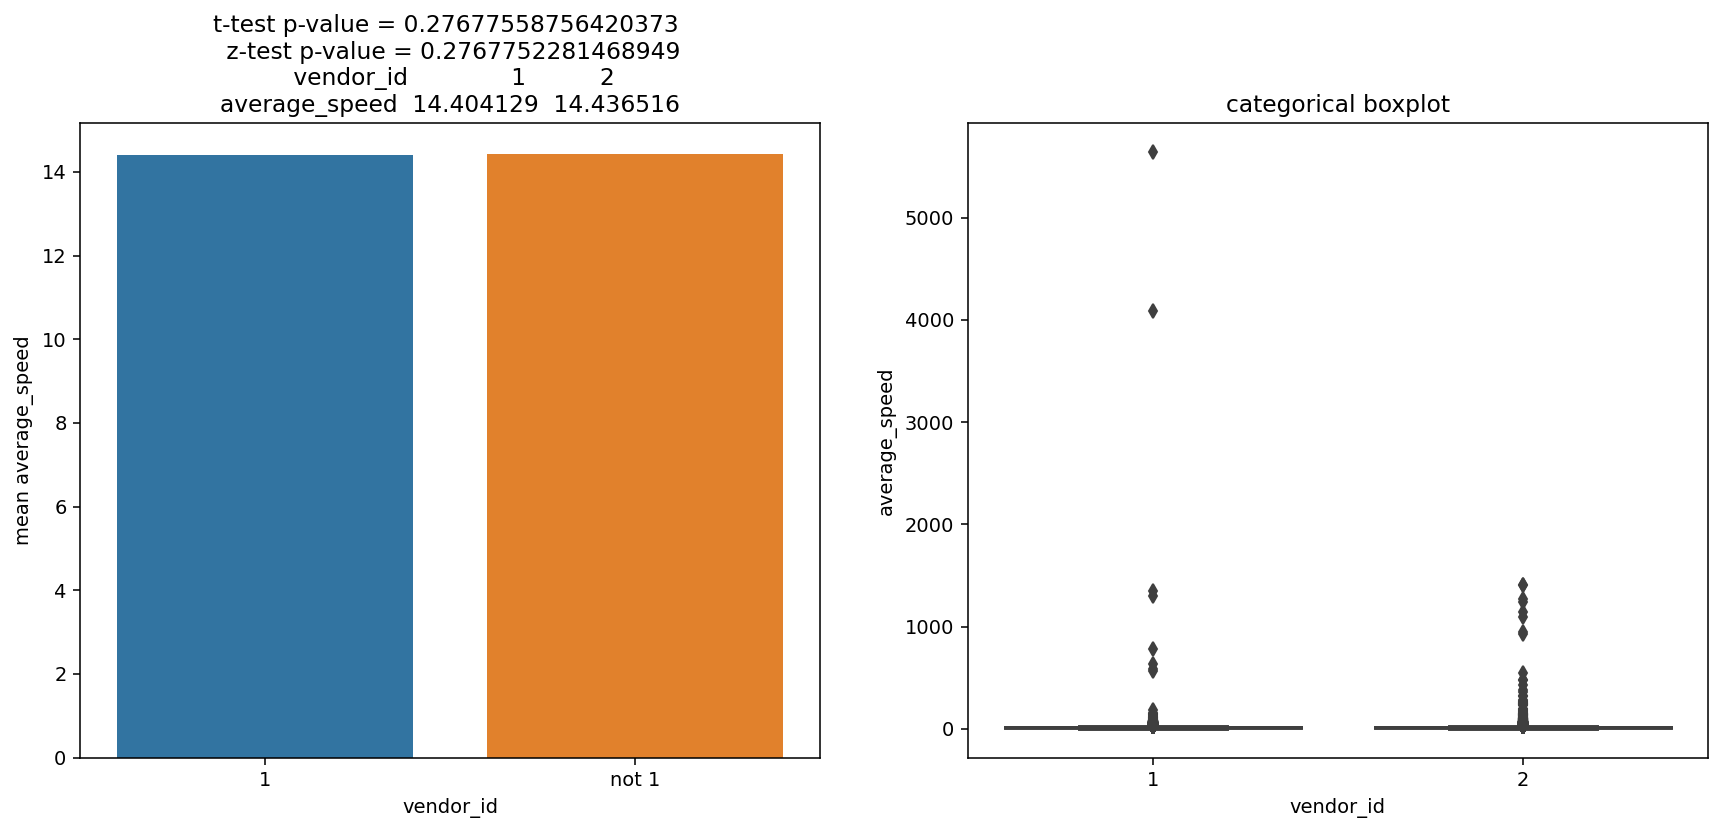

In [53]:
Bivariate_cont_cat(trip_dur, 'average_speed', 'vendor_id', 1)

In [54]:
### From the hypothesis test on average speed and vendor id, 
### it is clear that there is no significant difference between the average speeds of the trips among the two vendors

In [55]:
### Let us go to our second hypthesis test, is there any difference between trip_durations between the two vendors?

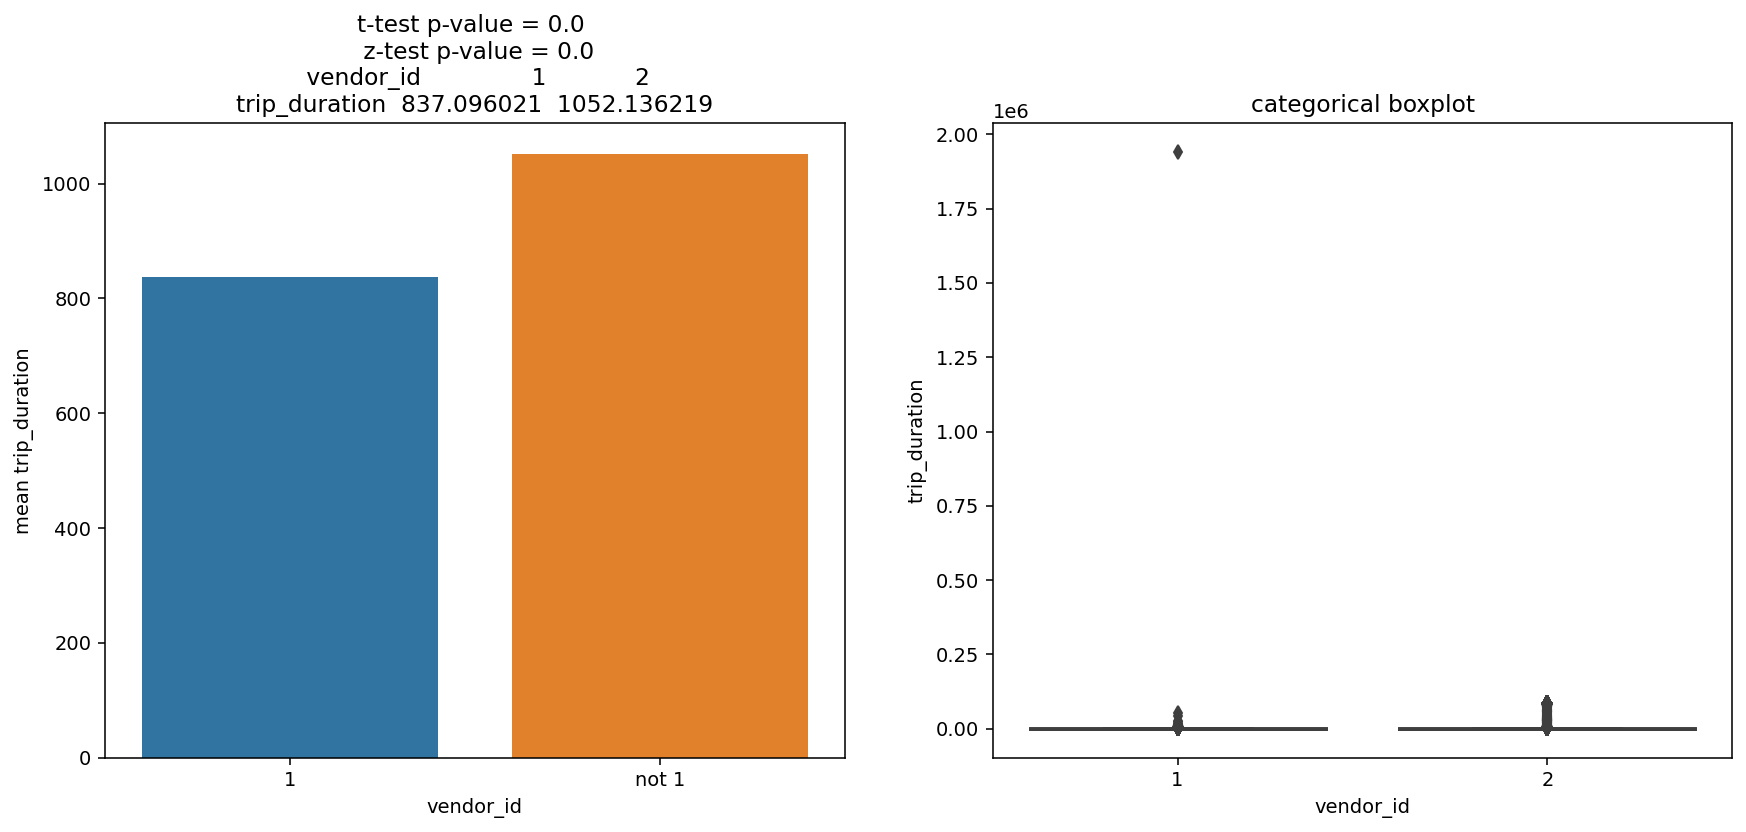

In [56]:
Bivariate_cont_cat(trip_dur, 'trip_duration', 'vendor_id', 1)

In [57]:
### From the previous hypothesis test we can see that the trip duration is more for vendor 2 compared to vendor 1

In [58]:
### For vendor 1, you can see significantly large outliers
### Remove the huge outliers and plot again
### Let's check trips below 50000 seconds only

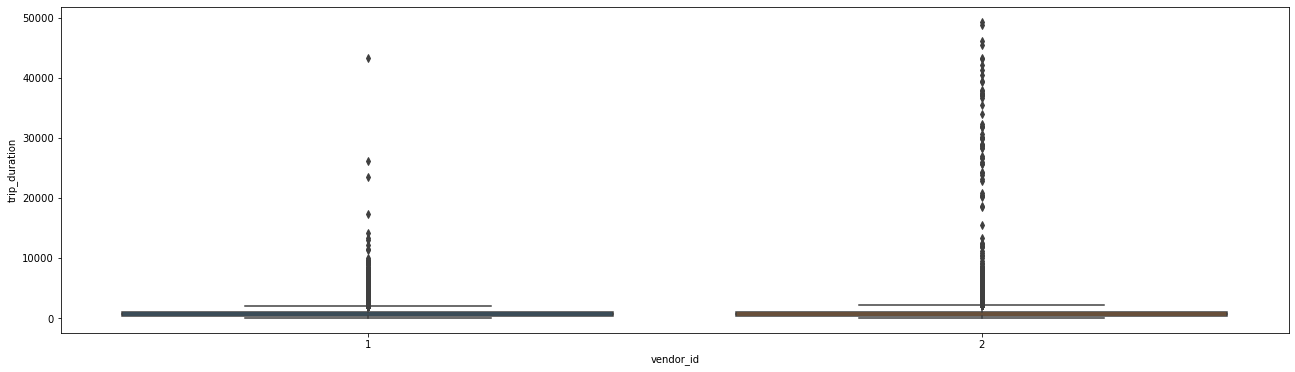

In [59]:
plt.figure(figsize=(22, 6))
trip_dur_sub = trip_dur[trip_dur['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=trip_dur_sub)
plt.show()

In [60]:
### As you can see, we were in a false perception earlier that vendor 1 had more outliers.
### We observe that vendor 2 has many more outliers as compared to vendor 1. 
### Let us try removing these potential outliers as well

In [61]:
upper_lim = np.percentile(trip_dur['trip_duration'],75,interpolation = 'midpoint')
lower_lim = np.percentile(trip_dur['trip_duration'],25,interpolation = 'midpoint')
IQR = upper_lim - lower_lim
upper = (upper_lim+1.5*IQR)
lower = (lower_lim-1.5*IQR)

trip_dur1 = trip_dur[(trip_dur['trip_duration'] < upper) & (trip_dur['trip_duration'] > lower)]

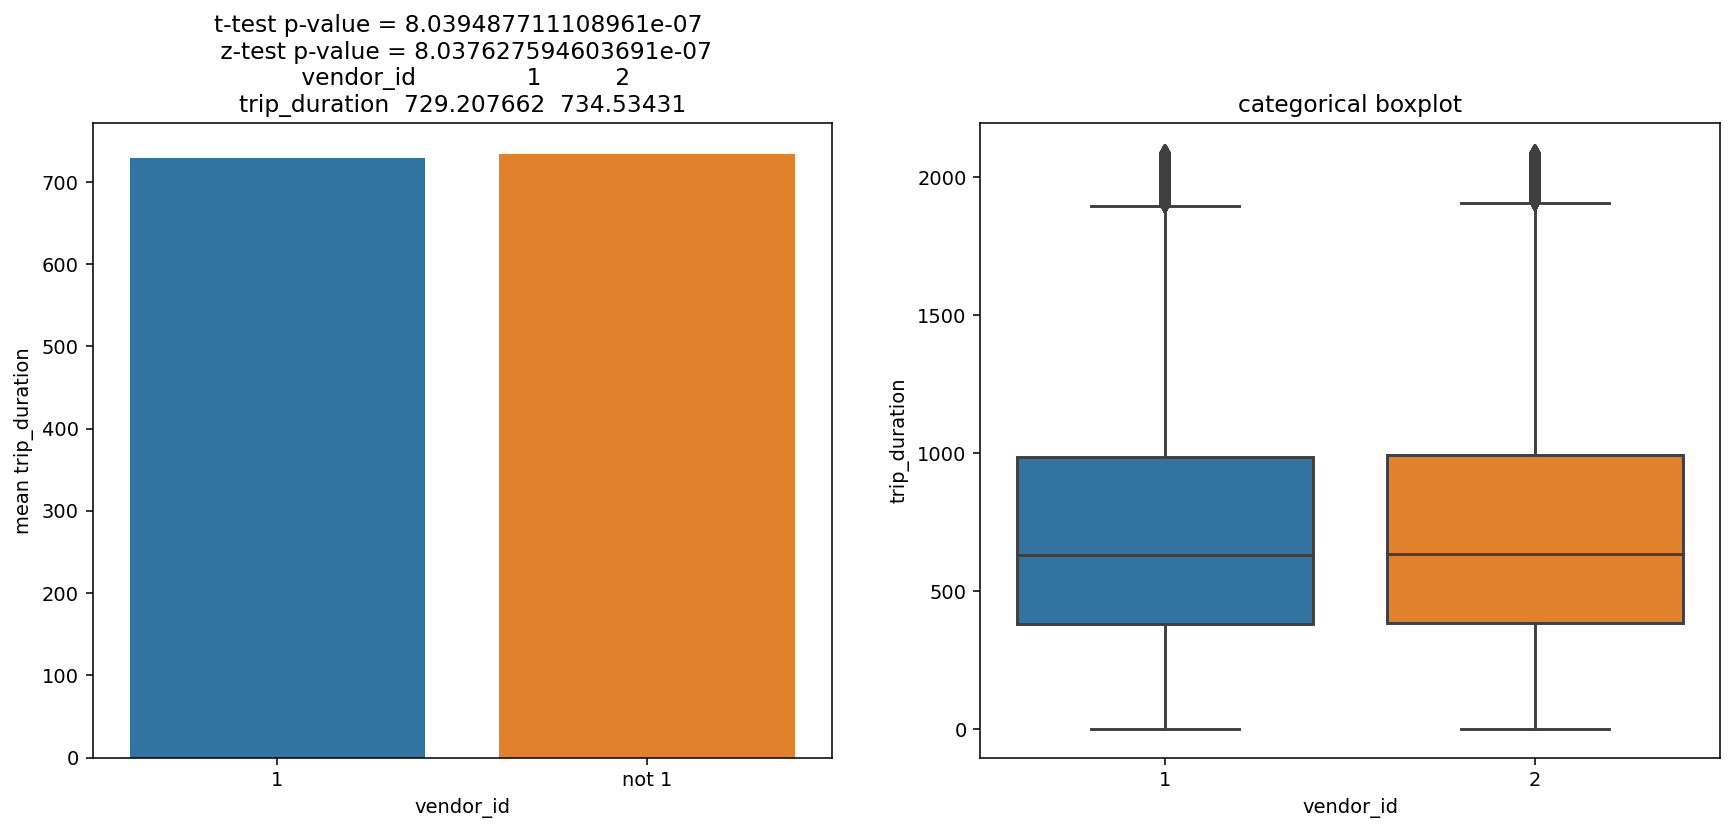

In [62]:
Bivariate_cont_cat(trip_dur1, 'trip_duration', 'vendor_id', 1)

In [63]:
### We can see that the box plots are more clear now.
### One point to be noted is that we can see from the box plots that the median trip duration 
### is almost similar for both vendors which is clear from the p values as well
### Before outlier removal, both vendors showed significant difference in trip duration when considering median
### Let us try using mean trip duration and compare between the two vendors

In [64]:
### Let us try using a different central tendency measure called mean
### Firstly let us use the data set without outlier removal
### We can see that there is a significant difference between vendors when outliers are not removed

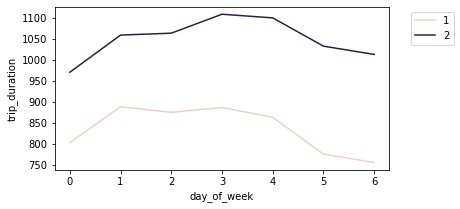

In [65]:
plt.figure(figsize=(6, 3))
trip_mean = pd.DataFrame(trip_dur.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
trip_mean.reset_index(inplace = True)
sns.lineplot(x='day_of_week', y='trip_duration', data=trip_mean, hue='vendor_id')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

In [66]:
### Now let us use the data set with outlier removed
### We can see that there is no significant difference between vendors when outliers are not removed

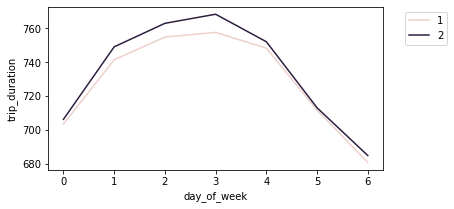

In [67]:
plt.figure(figsize=(6, 3))
trip_mean = pd.DataFrame(trip_dur1.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
trip_mean.reset_index(inplace = True)
sns.lineplot(x='day_of_week', y='trip_duration', data=trip_mean, hue='vendor_id')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

In [68]:
### Mean trip duration vary as can be seen from the above plot for different vendors. 
### It can be seen from the two above seaborn line plots 
### Without removing the trip_duration outliers, median and mean trip_durations of both vendors varied
### However, once trip_duration outliers are removed, the mean and median trip durations of both vendors become comparable


In [69]:
### Hypothesis 3: Is vendor 2 covering more trip distance than vendor 1?

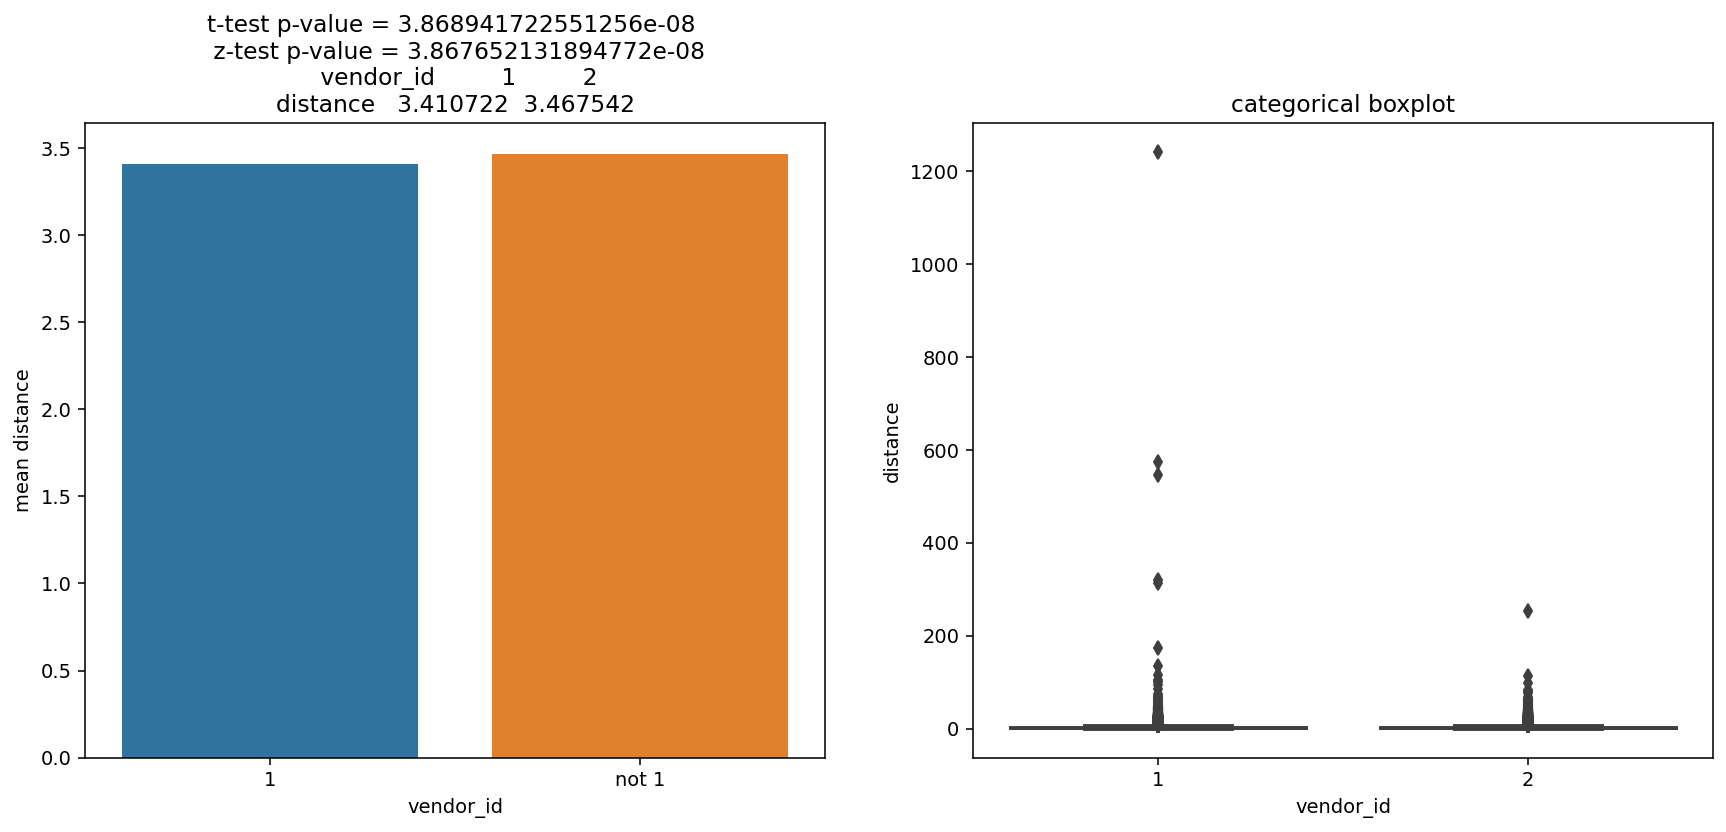

In [70]:
Bivariate_cont_cat(trip_dur, 'distance', 'vendor_id', 1)

In [71]:
### The hypothesis test reveals that distance covered during trips by both vendors is comparable 
### This aligns with our hypothesis test 1 which also showed that the average speed covered by both vendors is comparable

In [72]:
### Hypothesis 4:- Is average speed related to store_and_fwd_flag?

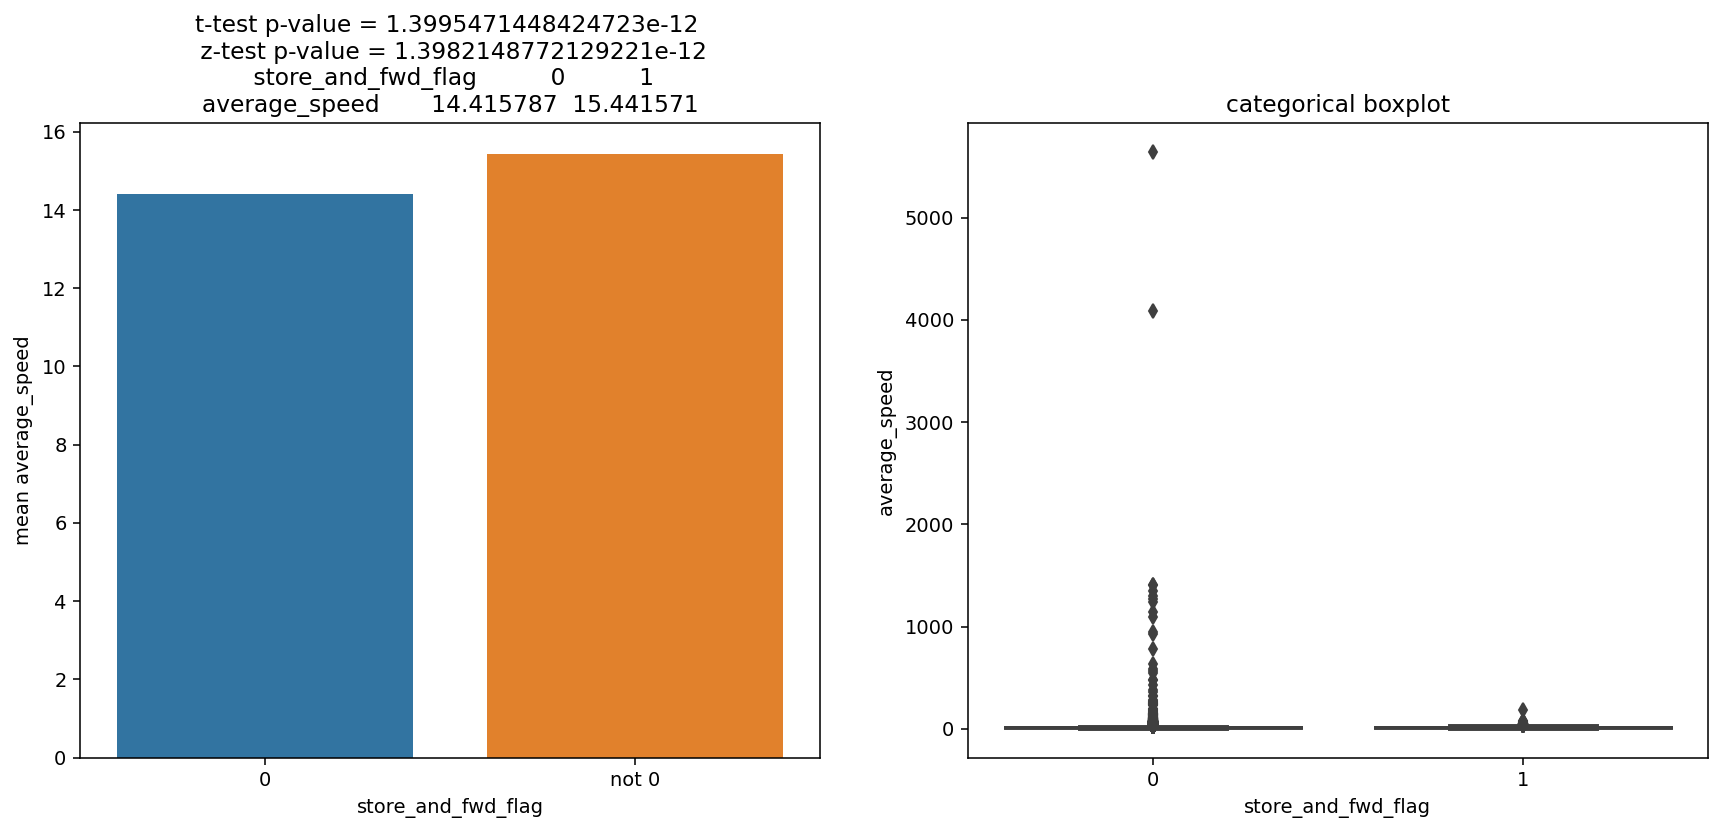

In [73]:
Bivariate_cont_cat(trip_dur, 'average_speed', 'store_and_fwd_flag', 0)

In [74]:
### The above analysis shows that there is a slight difference between average speed when store_and_fwd_flag is 0 and 1

In [75]:
### Hypothesis 5:- Is distance related to store_and_fwd_flag?

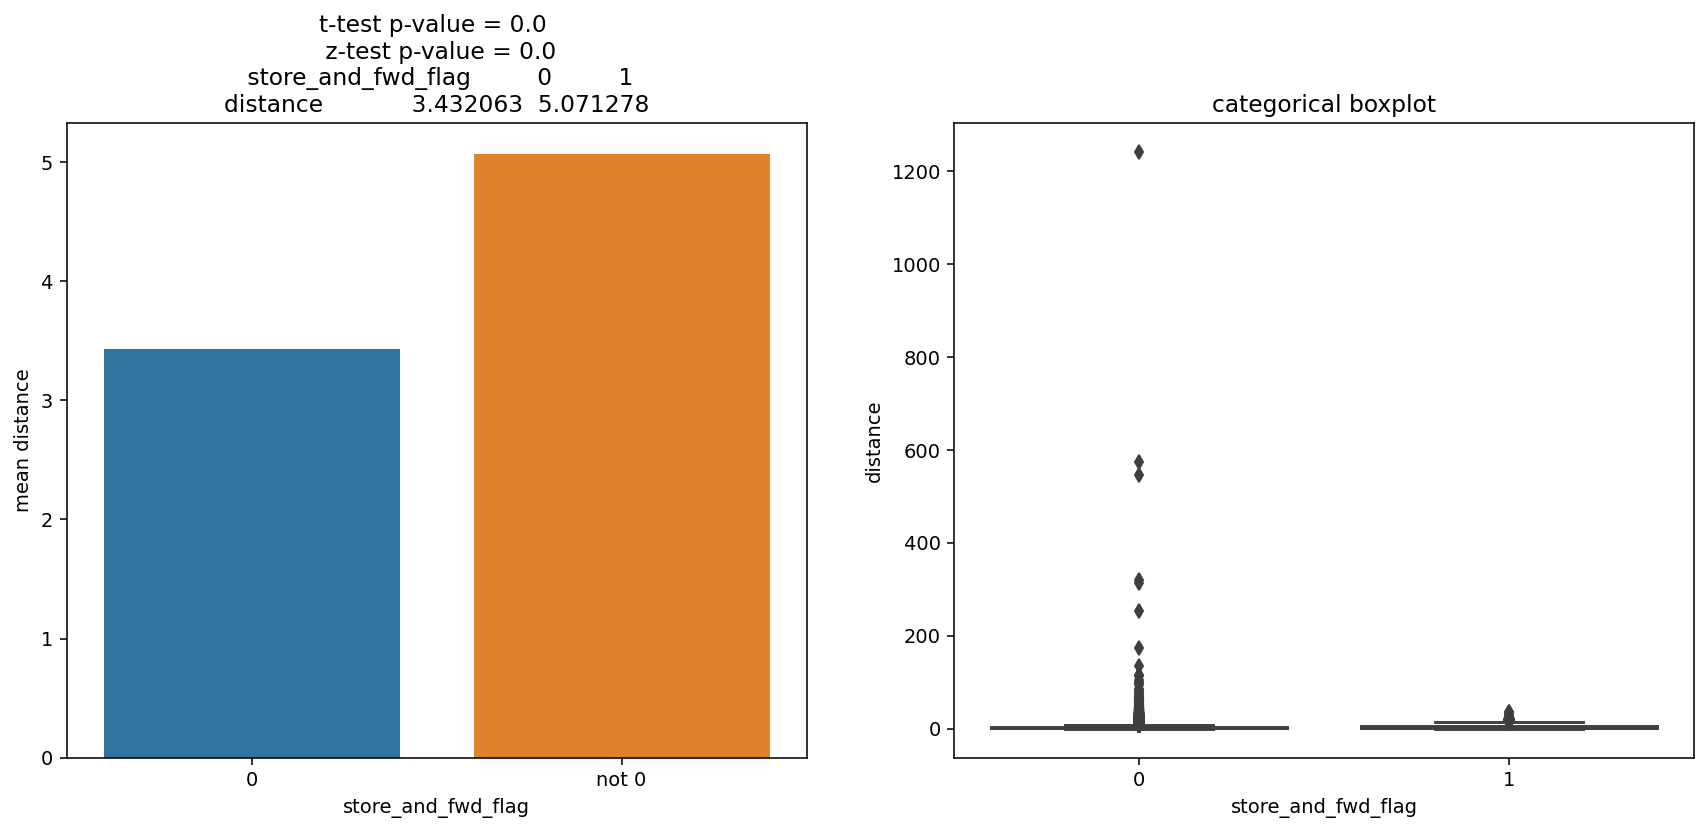

In [76]:
Bivariate_cont_cat(trip_dur, 'distance', 'store_and_fwd_flag', 0)

In [77]:
### Store and forward flag can be 0 or 1 and there is a significant difference on the distance covered when the flag is 0 and 1

In [78]:
### Hypothesis 6:- Is trip_duration related to store_and_fwd_flag?

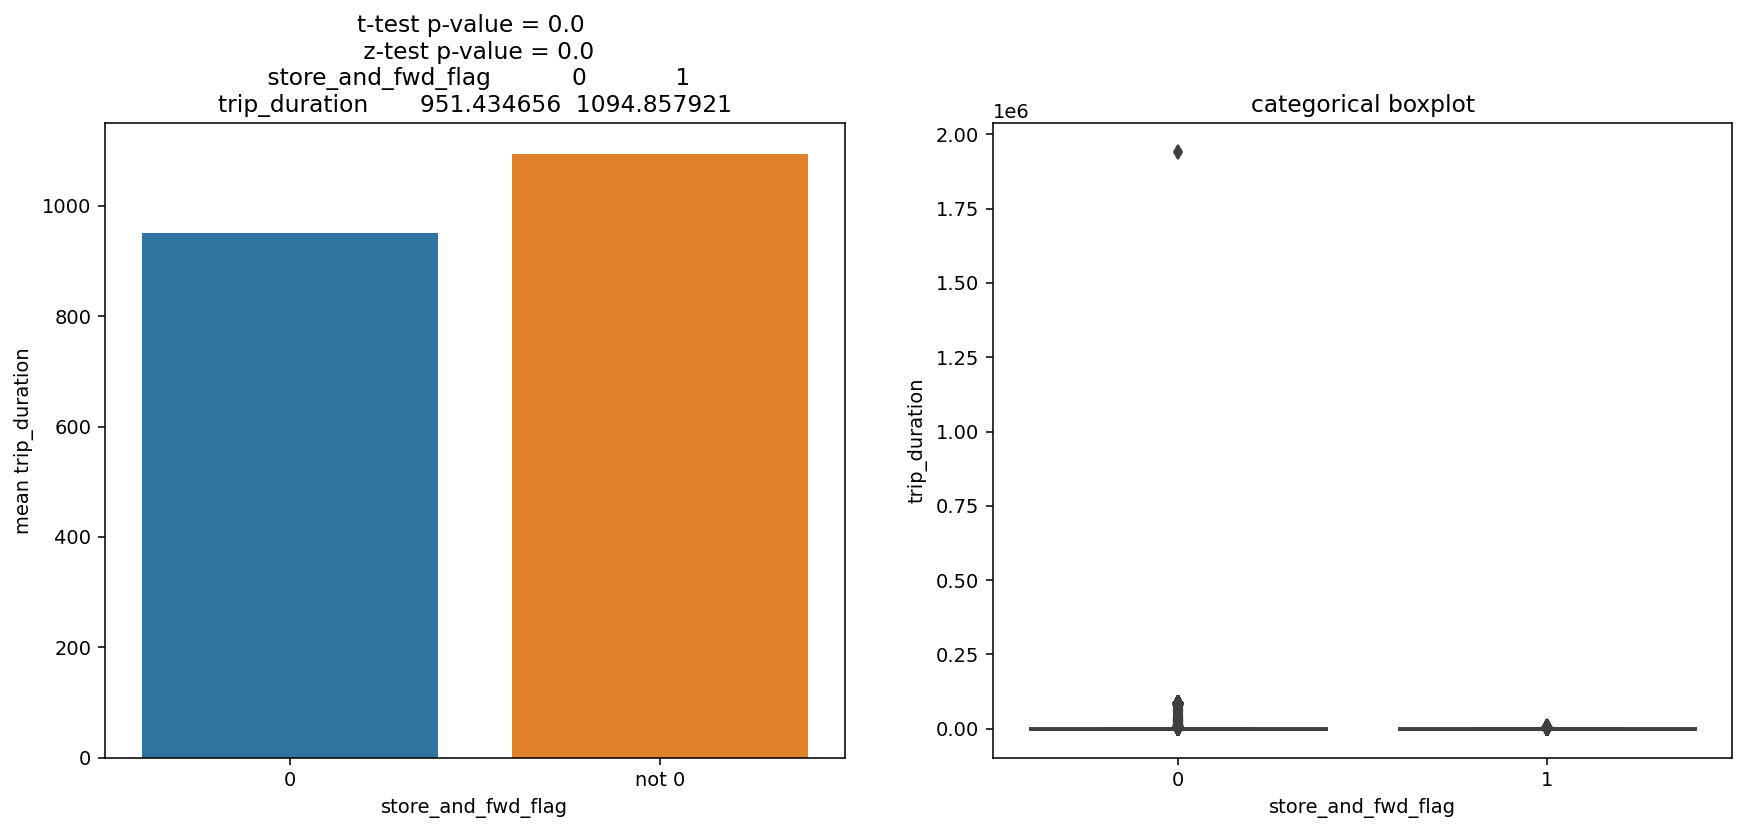

In [79]:
Bivariate_cont_cat(trip_dur, 'trip_duration', 'store_and_fwd_flag', 0)

In [80]:
## Store and forward flag can be 0 or 1 and there is a significant difference on the trip duration the flag is 0 and 1

In [81]:
### Hypothesis 7:-Are there more trips during weekdays when compared to weekends

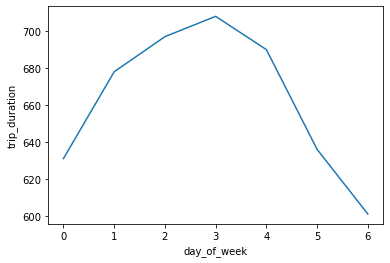

In [82]:
trip_day = pd.DataFrame(trip_dur.groupby(['day_of_week'])['trip_duration'].median())
trip_day.reset_index(inplace = True)
sns.lineplot(trip_day['day_of_week'],trip_day['trip_duration'])
plt.show()

In [83]:
### The maximum trip duration occurs during day 3 and minimum on day 6 (Saturday)

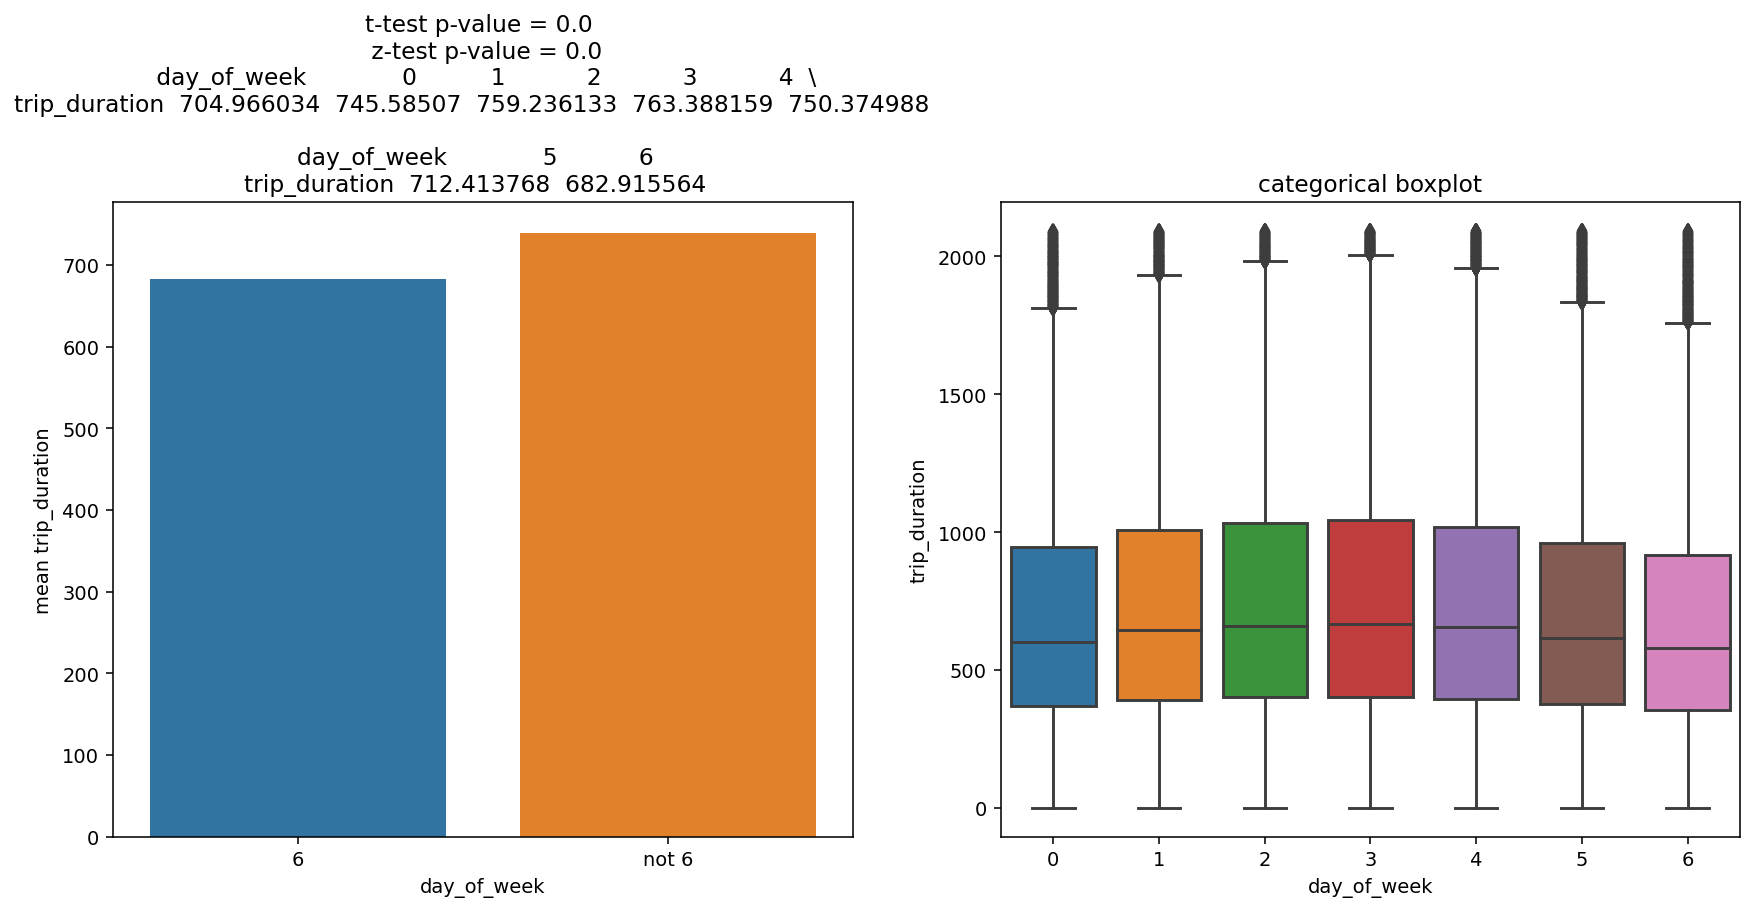

In [84]:
Bivariate_cont_cat(trip_dur1, 'trip_duration', 'day_of_week', 6)

In [85]:
### The above shows that there is a significant difference between the trip_duration on saturday compared 
### to mean trip_duration on other days
### We have used the data set with outliers on trip duration removed

In [86]:
### Hypothesis 8: Is there difference in Trip duration with respect to time of day

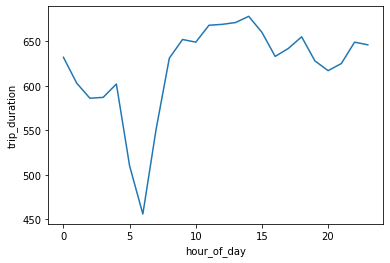

In [87]:
trip_hour = pd.DataFrame(trip_dur1.groupby(['hour_of_day'])['trip_duration'].median())
trip_hour.reset_index(inplace = True)
sns.lineplot(trip_hour['hour_of_day'],trip_hour['trip_duration'])
plt.show()

In [88]:
### Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
### Trip duration is least around 6 am

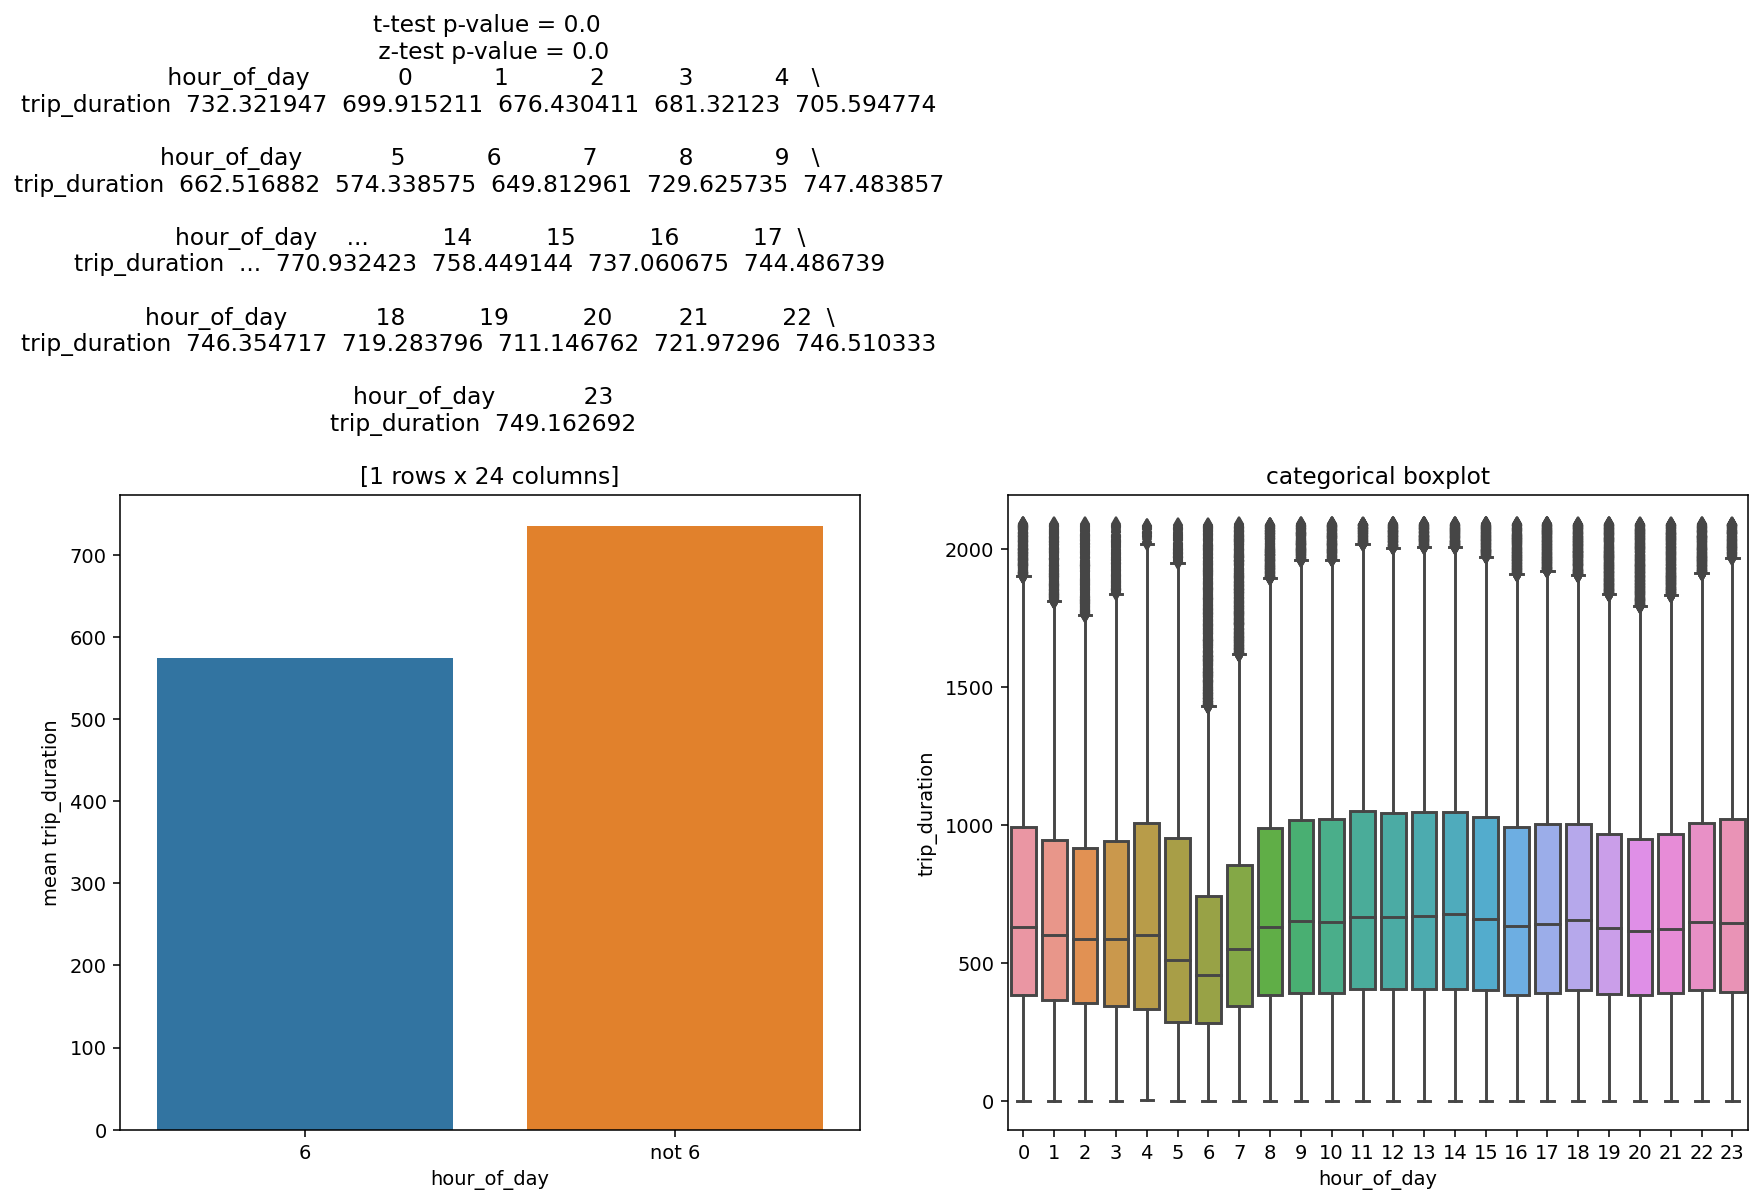

In [89]:
Bivariate_cont_cat(trip_dur1, 'trip_duration', 'hour_of_day', 6)

In [90]:
### The analysis tried to see if there is a significant difference between trip duration around 6 am where trip duration is least
### Hypothesis test revealed that there is significantly lower trip duration around 6 am

In [91]:
### Hypothesis 9:- Is there significant difference between trip duration with passenger count

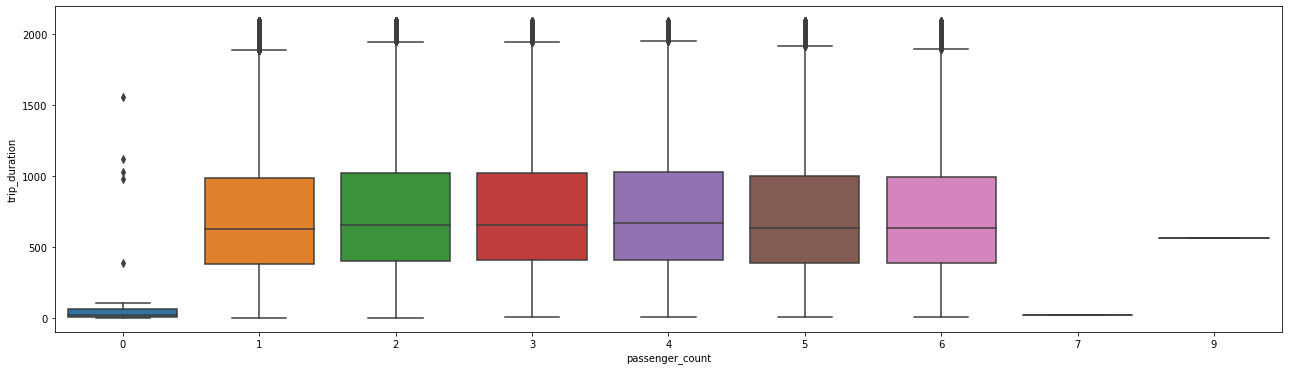

In [92]:
trip_dur1.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
sns.boxplot(x="passenger_count", y="trip_duration", data=trip_dur1)
plt.show()

In [93]:
### We can see that the median trip duration of different passenger counts is comparable

In [94]:
### Let us now look at the multivariate analysis
### First of all, let us look at the pivot tables

In [95]:
### Let us see how mean trip duration differs with respect to vendors and passenger counts

In [96]:
trip_dur1.pivot_table('trip_duration', 'vendor_id','passenger_count', aggfunc='sum')

passenger_count,0,1,2,3,4,5,6,7,9
vendor_id,,,,,,,,,
1,3838.0,188931155.0,33263181.0,8388054.0,4433951.0,112046.0,62039.0,NaN,NaN
2,1808.0,168782823.0,40878454.0,12762673.0,5549473.0,26990854.0,16646495.0,19.0,560.0


In [97]:
### We can see that the total trip duration is highest for vendor count 1 with passenger count of 1
### Trips with zero passenger that means the booking might be cancelled due to some reason
### It seems that vendor 1 does not have trips with passenger counts of 7 and 9

In [98]:
trip_dur1.pivot_table('distance', 'vendor_id','passenger_count', aggfunc='sum')

passenger_count,0,1,2,3,4,5,6,7,9
vendor_id,,,,,,,,,
1,18.003787,752834.272412,132730.391816,31979.794938,17101.797236,408.186793,313.643064,NaN,NaN
2,7.373174,672407.286866,163380.883521,50670.481512,22067.276789,108348.002252,65404.255118,0.002625,0.0


In [99]:
### We can see that the total distance is highest for vendor count 1 with passenger count of 1
### Trips with zero passenger that means the booking might be cancelled due to some reason
### It seems that vendor 1 does not have trips with passenger counts of 7 and 9

In [100]:
### To analyze how trip duration varies with different hours of day, let us split the hours of day into 4 time slots

In [101]:
hours = pd.cut(trip_dur1['hour_of_day'], [0, 6, 12, 18,24])

In [102]:
trip_dur1.pivot_table('trip_duration',['vendor_id',hours], aggfunc='sum')

trip_duration
vendor_id hour_of_day               
1         (0, 6]            23567170
          (6, 12]           64025704
          (12, 18]          72821456
          (18, 24]          66143654
2         (0, 6]            25298424
          (6, 12]           74742544
          (12, 18]          83166915
          (18, 24]          78025352

In [103]:
### We can see from the above pivot table that for both vendors 1 and 2, time slot between 12 and 18 has the maximum trip durations

In [104]:
trip_dur1.pivot_table('trip_duration',['passenger_count',hours], aggfunc='sum')

trip_duration
passenger_count hour_of_day               
0               (0, 6]                1290
                (6, 12]               1559
                (12, 18]              1075
                (18, 24]              1557
1               (0, 6]            34359758
                (6, 12]          102004695
                (12, 18]         109176540
                (18, 24]          99280939
2               (0, 6]             7084912
                (6, 12]           17327394
                (12, 18]          23437099
                (18, 24]          23000919
3               (0, 6]             2130071
                (6, 12]            4920063
                (12, 18]           6779497
                (18, 24]           6482531
4               (0, 6]              999217
                (6, 12]            2227921
                (12, 18]           3199448
                (18, 24]           3153553
5               (0, 6]             2641172
                (6, 12]            7418397
                (12, 18]           8216177
                (18, 24]           7780936
6               (0, 6]             1649174
                (6, 12]            4867640
                (12, 18]           5178535
                (18, 24]           4468571
7               (0, 6]                   0
                (6, 12]                 19
                (12, 18]                 0
                (18, 24]                 0
9               (0, 6]                   0
                (6, 12]                560
                (12, 18]                 0
                (18, 24]                 0

In [105]:
### We can see that for passenger count 1, except for early morning slot 0-6, all slots have comparably very high trip durations
### This means that most of the taxis are hired for single passengers who may be commuting to or from their workplaces
### The next observation is that there are also significantly large trip durations with 2 passengers which shows the high trend of
### cab pooling or so

In [106]:
days = pd.cut(trip_dur1['day_of_week'], [0,5,6])

In [107]:
trip_dur1.pivot_table('trip_duration',['vendor_id',days], aggfunc='sum')

trip_duration
vendor_id day_of_week               
1         (0, 5]           176337399
          (5, 6]            29606222
2         (0, 5]           203315222
          (5, 6]            34515452

In [108]:
### We can see that from sunday to friday, trip duration is signifcantly large compared to saturday for both the vendors
### This shows that most of the employees prefer to stay at home on saturdays

In [109]:
trip_dur1.pivot_table('trip_duration',['passenger_count',days], aggfunc='sum')

trip_duration
passenger_count day_of_week               
0               (0, 5]                5412
                (5, 6]                 180
1               (0, 5]           269357680
                (5, 6]            43074647
2               (0, 5]            54608282
                (5, 6]            10684420
3               (0, 5]            15455417
                (5, 6]             3191557
4               (0, 5]             7308380
                (5, 6]             1499382
5               (0, 5]            20363143
                (5, 6]             3554193
6               (0, 5]            12553728
                (5, 6]             2117295
7               (0, 5]                  19
                (5, 6]                   0
9               (0, 5]                 560
                (5, 6]                   0

In [110]:
### As expected on weekdays from sunday to friday, maximum trip durations happen and that too with passenger count of 1

In [111]:
### As a part of multivariate analysis, let us also look at grouped box plots for better visualization

In [112]:
### Let us define a function
def Grouped_Box_Plot(data, cont, cat1, cat2):
    sns.boxplot(x=cat1, y=cont, hue=cat2, data=data, orient='v')
    plt.title('Boxplot')


In [113]:
### Let us see how trip duration varies with different vendors and store_and_fwd_flag

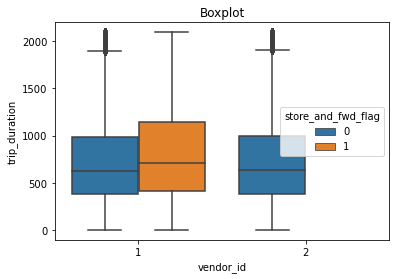

In [114]:
Grouped_Box_Plot(trip_dur1,'trip_duration', 'vendor_id', 'store_and_fwd_flag')

In [115]:
### None of the trip durations with vendor_id 2 has store_and_fwd_flag
### In case of trips by vendor 1, trip duration is more with store_and_fwd_flag 1 

In [116]:
### Let us now try for a grouped box plot that shows the variation of trip duration with different vendors and passenger counts

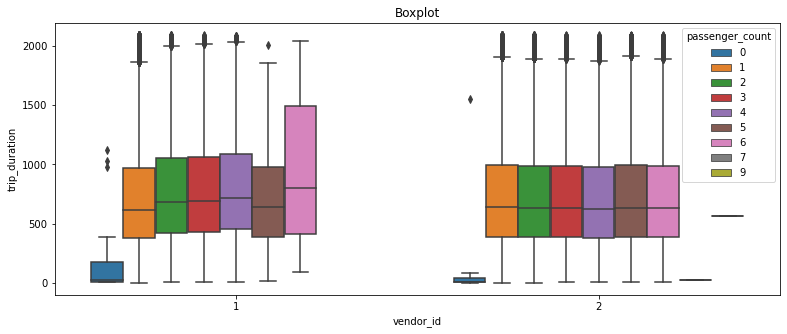

In [117]:
plt.figure(figsize=(13, 5))
Grouped_Box_Plot(trip_dur1,'trip_duration', 'vendor_id', 'passenger_count')

In [118]:
### It is interesting to note that the median trip duration is same for all passenger counts in case of vendor 2
### For vendor 1, the median trip duration varies with passenger count and is highest for passenger count 6

In [119]:
### Let us see how trip duration varies with vendors over days of a week

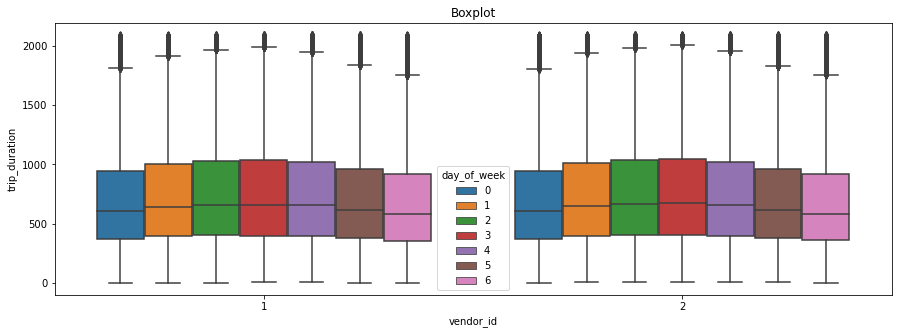

In [120]:
plt.figure(figsize=(15, 5))
Grouped_Box_Plot(trip_dur1,'trip_duration', 'vendor_id', 'day_of_week')

In [121]:
### It is interesting to note that the pattern of trip duration over days of a week is similar for both vendors

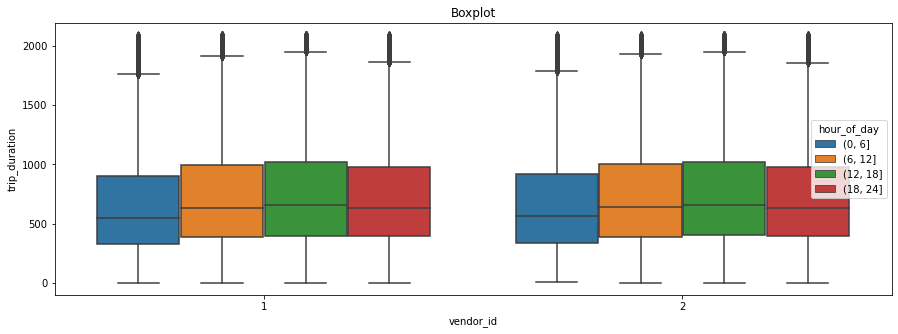

In [122]:
plt.figure(figsize=(15, 5))
Grouped_Box_Plot(trip_dur1,'trip_duration', 'vendor_id', hours)

In [123]:
### Its interesting to note that the pattern of trip duration over time slots of a day is similar for both vendors

In [124]:
### Model Deployment 

In [125]:
### 1.Choose the most suitable evaluation metric and state why you chose it

### Predicting the trip_duration is a regression problem.
### In machine Learning, our main goal is to minimize the error which is defined by the Loss Function.
### We can use MSE or RMSE or R-squared here.

In [126]:
### 2.Benchmark Model

### In baseline model the predicted trip time would be simply the average of all trip time.
### We will use this baseline model to perform hypothesis testing for other ML complex models.

In [127]:
trip_dur1.drop('id', axis = 1,inplace=True)

In [128]:
### Let us choose the features that we are going to use in our modeling

In [129]:
variables = ['vendor_id','passenger_count','store_and_fwd_flag','day_of_week','hour_of_day','month','distance','trip_duration']
trip_dur1 = trip_dur1[variables]
trip_dur1.head(3)

,vendor_id,passenger_count,store_and_fwd_flag,day_of_week,hour_of_day,month,distance,trip_duration
0,2,1,0,0,16,2,1.199074,400
1,1,2,0,4,23,3,4.129117,1100
2,2,2,0,6,17,2,7.250763,1635


In [130]:
x = trip_dur1.drop('trip_duration',axis=1)
y = trip_dur1['trip_duration']

In [131]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y, random_state = 0)

In [132]:
# Importing the MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled, columns = x.columns)
x.head()

,vendor_id,passenger_count,store_and_fwd_flag,day_of_week,hour_of_day,month,distance
0,1.0,0.111111,0.0,0.000000,0.695652,0.2,0.000966
1,0.0,0.222222,0.0,0.666667,1.000000,0.4,0.003327
2,1.0,0.222222,0.0,1.000000,0.739130,0.2,0.005843
3,1.0,0.666667,0.0,0.166667,0.391304,0.0,0.001903
4,0.0,0.111111,0.0,0.333333,0.260870,0.2,0.003488


In [133]:
### The evaluation Metric that we are going to use is R Squared (Coefficient of Determination). 
### It tells the performance of your model, not the loss in an absolute sense
### R-squared score is is easy to comapre all models.

In [134]:
from sklearn.metrics import r2_score as r2

In [135]:
# Calculating R Squared Error of Training Data
benchmark_train = np.empty(len(y_train)) + y_train.mean() 
benchmark_train_error = r2(benchmark_train , y_train)
print('Train R-Squared Error of benchmark model ', benchmark_train_error)

# Calculating R Squared Error of Testing Data
benchmark_test = np.empty(len(y_test)) + y_test.mean() 
benchmark_test_error = r2(benchmark_test , y_test)
print('Test R Squared Error', benchmark_test_error)

Train R-Squared Error of benchmark model  -3.1711513702446184e+29
Test R Squared Error -3.882106861069987e+30


In [136]:
### Negative value is because model is not learning the train data because we have taken the mean as the benchmark model

In [137]:
### 3. Build a K-Nearest neighbours’ model for the given dataset and find the best value of k
### Now let us implement KNN Regressor

In [138]:
from sklearn.neighbors import KNeighborsRegressor as KNN
reg = KNN(n_neighbors = 5)
reg.fit(x_train, y_train)

# Predicting over the Train Set
knn_train_predict = reg.predict(x_train)
knn_train_error = r2(knn_train_predict, y_train)
print('Train R Squared Error', knn_train_error )

# Predicting over the Test Set
knn_test_predict = reg.predict(x_test)
knn_test_error = r2(knn_test_predict, y_test)
print('Test R Squared Error', knn_test_error )

Train R Squared Error 0.6314265796120018
Test R Squared Error 0.44470994317103163


Text(0.5, 1.0, 'Elbow Curve for test')

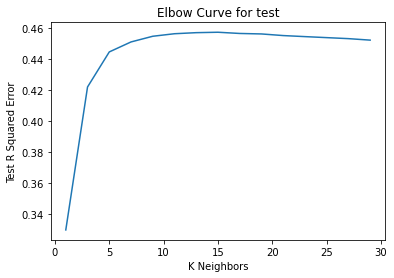

In [139]:
### Elbow method to find the best value of k for knn
def Elbow(K):
    
    test_r2 = []
    for i in K:
        reg = KNN(n_neighbors = i)
        reg.fit(x_train, y_train)
        temp = reg.predict(x_test)
        temp = r2(temp,y_test)
        test_r2.append(temp)
    return test_r2

k = range(1,30,2)
test = Elbow(k)

# Plotting the Curves
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test R Squared Error')
plt.title('Elbow Curve for test')

In [140]:
### R-squared value is best near to k-value of 10

In [141]:
reg = KNN(n_neighbors = 10)
reg.fit(x_train, y_train)

# Predicting over the Train Set
knn_train_predict = reg.predict(x_train)
knn_train_error = r2(knn_train_predict, y_train)
print('Train R Squared Error', knn_train_error )

# Predicting over the Test Set
knn_test_predict = reg.predict(x_test)
knn_test_error = r2(knn_test_predict, y_test)
print('Test R Squared Error', knn_test_error )

Train R Squared Error 0.5571880954315036
Test R Squared Error 0.45597394097016375


In [142]:
### 4. Build a Linear model for the given dataset with regularisation. Attempt to interpret the variable coefficients 

In [143]:
### Let us try to fit a linear regression model to our data set

In [144]:
#importing Linear Regression
from sklearn.linear_model import LinearRegression as LR
lr = LR(normalize = True)
lr.fit(x_train, y_train)

# Predicting over the Train Set and calculating error
lg_train_predict = lr.predict(x_train)
lg_train_error = r2(lg_train_predict, y_train)
print('Training R Squared Error', lg_train_error )

# Predicting over the Test Set and calculating error
lg_test_predict = lr.predict(x_test)
lg_test_error = r2(lg_test_predict, y_test)
print('Test R Squared Error', lg_test_error )

Training R Squared Error -0.22584297245221197
Test R Squared Error -0.11723699109387953


In [145]:
### Negative R-squared value shows that 
### the performance of linear regression model is not good, although it is better than benchmark model

In [146]:
### Linear regression with ridge regularization

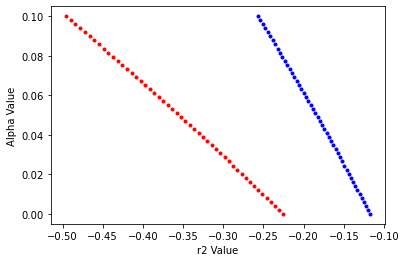

In [147]:
# Importing ridge from sklearn's linear_model module
from sklearn.linear_model import Ridge

#Find the values of alpha to find good R-squared values
for i in np.linspace(0.00001,0.1,50): 
    ridge_reg = Ridge(alpha=i, normalize=True) 
    ridge_reg.fit(x_train, y_train) 

    # Predicting over the Train Set and calculating error
    ridge_train_predict = ridge_reg.predict(x_train)
    ridge_train_error = r2(ridge_train_predict, y_train)

    # Predicting over the Test Set and calculating error
    ridge_test_predict = ridge_reg.predict(x_test)
    ridge_test_error = r2(ridge_test_predict, y_test)
    
    plt.plot(ridge_train_error, i, color = 'Red', marker = '.')
    plt.plot(ridge_test_error, i, color = 'Blue', marker = '.')
    plt.ylabel('Alpha Value')
    plt.xlabel('r2 Value')
plt.show()

In [148]:
### The above shows that even with ridge regression, model performs at its best at negative R-squared values
### The model, like simple linear regression is not good at predicting trip duration

In [149]:
# Creating instance of Linear Regresssion with Normalised Data
ridge_reg = Ridge(alpha=0.0001, normalize=True) 
ridge_reg.fit(x_train, y_train) 

# Predicting over the Train Set and calculating error
ridge_train_predict = ridge_reg.predict(x_train)
ridge_train_error = r2(ridge_train_predict, y_train)
print('Training R Squared Error', ridge_train_error )

# Predicting over the Test Set and calculating error
ridge_test_predict = ridge_reg.predict(x_test)
ridge_test_error = r2(ridge_test_predict, y_test)
print('Testing R Squared Error', ridge_test_error )

Training R Squared Error -0.22609048855679226
Testing R Squared Error -0.11736487903574999


Text(0.5, 1.0, 'Coefficient plot')

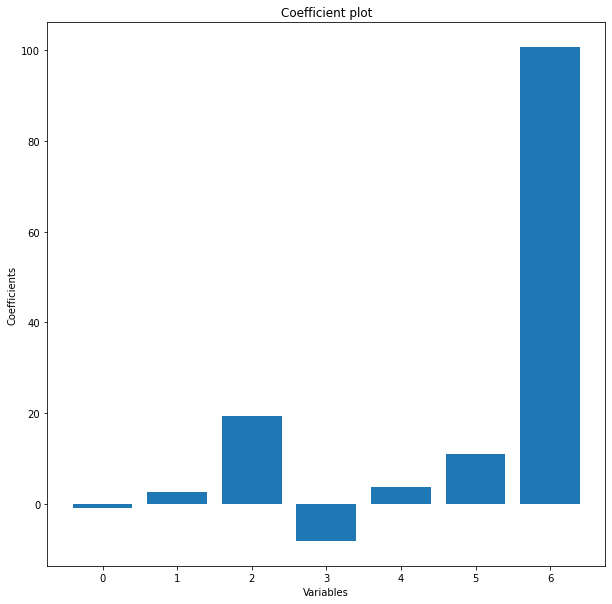

In [150]:
plt.figure(figsize=(10, 10))
x = range(len(x_train.columns))
y = ridge_reg.coef_
plt.bar(x,y)
plt.xlabel( 'Variables')
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

In [151]:
### Our features are:
###  ['vendor_id','passenger_count','store_and_fwd_flag','day_of_week','hour_of_day','month','distance']
### The most prominent feature is feature 6, which is distance that shows that distance has a role in predicting trip duration

In [152]:
### Linear regression with lasso regularization

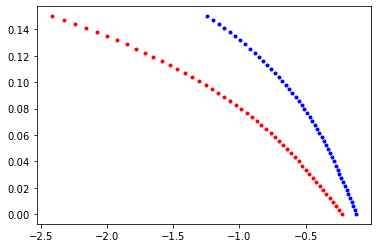

In [153]:
# Importing ridge from sklearn's linear_model module
from sklearn.linear_model import Lasso

# Iterate through various values of alpha to find the lowest r2
for i in np.linspace(0.0001,0.15,50): 
    lasso_reg = Lasso(alpha=i, normalize=True) 
    lasso_reg.fit(x_train, y_train) 

    # Predicting over the Train Set and calculating error
    lasso_train_predict = lasso_reg.predict(x_train)
    lasso_train_error = r2(lasso_train_predict, y_train)

    # Predicting over the Test Set and calculating error
    lasso_test_predict = lasso_reg.predict(x_test)
    lasso_test_error = r2(lasso_test_predict, y_test)
    
    plt.plot(lasso_train_error, i, color = 'Red', marker = '.')
    plt.plot(lasso_test_error, i, color = 'Blue', marker = '.')
plt.show()

In [154]:
### Lasso regularized regression also performs poorly like ridge, R-squared value is very low

In [155]:
# Creating instance of Linear Regresssion with Normalised Data
lasso_reg = Lasso(alpha=0.0001, normalize=True) 
lasso_reg.fit(x_train, y_train) 

# Predicting over the Train Set and calculating error
lasso_train_predict = lasso_reg.predict(x_train)
lasso_train_error = r2(lasso_train_predict, y_train)
print('Training R Squared Error', lasso_train_error )

# Predicting over the Test Set and calculating error
lasso_test_predict = lasso_reg.predict(x_test)
lasso_test_error = r2(lasso_test_predict, y_test)
print('Testing R Squared Error', lasso_test_error )

Training R Squared Error -0.2265570965594279
Testing R Squared Error -0.11759821163206352


Text(0.5, 1.0, 'Coefficient plot')

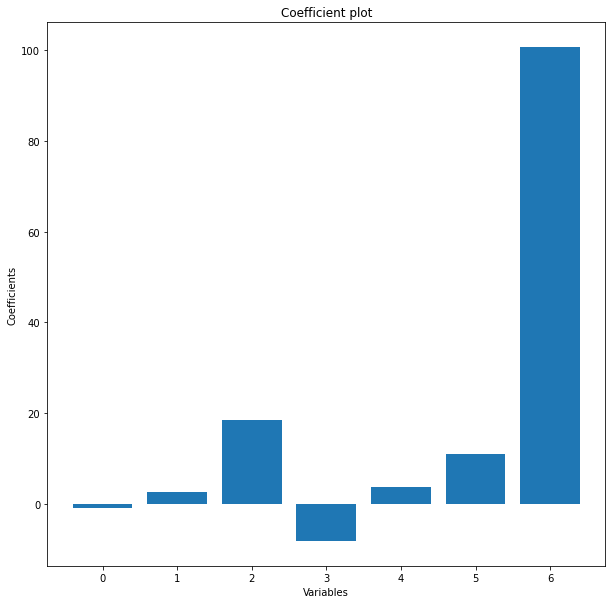

In [156]:
plt.figure(figsize=(10, 10))
x = range(len(x_train.columns))
y = lasso_reg.coef_
plt.bar(x,y)
plt.xlabel( 'Variables')
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

In [157]:
### Our features are:
###  ['vendor_id','passenger_count','store_and_fwd_flag','day_of_week','hour_of_day','month','distance']
### The most prominent feature is feature 6, which is distance that shows that distance has a role in predicting trip duration

In [158]:
### 5. Build a Decision tree model for the given dataset. Attempt to interpret the variable importance

In [159]:
# Importing the Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(random_state=50)

# Fitting the model
dt_reg.fit(x_train, y_train)

# Predicting over the Train Set and calculating error
dt_train_predict = dt_reg.predict(x_train)
dt_train_error = r2(dt_train_predict, y_train)
print('Training R Squared Error', dt_train_error )

# Predicting over the Test Set and calculating error
dt_test_predict = dt_reg.predict(x_test)
dt_test_error = r2(dt_test_predict, y_test)
print('Testing R Squared Error', dt_test_error )

Training R Squared Error 0.9990592138967697
Testing R Squared Error 0.32046151586252214


In [160]:
### We can see that the training r-squared is very good, however when it comes to testing, it got low
### Let us try to fine tune our parameters using Grid search

In [161]:
from sklearn.model_selection import GridSearchCV

# Maximum depth of trees
max_depth = [19,20,21,22]

# Minimum number of samples required to split a node
min_samples_split = [1,2,3,4,5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4,5]

# HYperparameter Grid
param_dt = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Grid search
dt_grid = GridSearchCV(estimator=dt_reg, param_grid = param_dt)

dt_grid.fit(x_train,y_train)

print(dt_grid.best_score_)
print(dt_grid.best_estimator_)

0.5872388751572697
DecisionTreeRegressor(max_depth=19, min_samples_leaf=5, random_state=50)


In [162]:
dt_reg = DecisionTreeRegressor(max_depth = 19, min_samples_leaf = 5, min_samples_split = 5, random_state = 50)

# Fitting the model
dt_reg.fit(x_train, y_train)

# Predicting over the Train Set and calculating error
dt_train_predict = dt_reg.predict(x_train)
dt_train_error = r2(dt_train_predict, y_train)
print('Training R Squared Error', dt_train_error )

# Predicting over the Test Set and calculating error
dt_test_predict = dt_reg.predict(x_test)
dt_test_error = r2(dt_test_predict, y_test)
print('Testing R Squared Error', dt_test_error )

Training R Squared Error 0.6595615752725723
Testing R Squared Error 0.44532485781676867


In [163]:
importance_dict = {'Feature' : list(x_train.columns), 'Feature Importance' : dt_reg.feature_importances_}

importance_dict = pd.DataFrame(importance_dict)

importance_dict.sort_values(by=['Feature Importance'], ascending=False, inplace=True)

importance_dict

,Feature,Feature Importance
6,distance,0.851824
4,hour_of_day,0.079746
3,day_of_week,0.037968
5,month,0.015692
1,passenger_count,0.008801
0,vendor_id,0.005832
2,store_and_fwd_flag,0.000136


In [164]:
### We can see here that distance is the most importance feature contributing 80% to importance

In [165]:
### 6. Plot the following Bar plots:
###    0. train score of all the above models.
###    1. test (not validation!) score of all the above models.
###    2. Attempt to explain the observations from the plots (optional)


In [166]:
test_r2 = [knn_train_error, lg_train_error, lasso_train_error, ridge_train_error, dt_train_error]
errors = [knn_test_error, lg_test_error, lasso_test_error, ridge_test_error, dt_test_error]
comparison = pd.DataFrame({'Train_Score': test_r2, 'Test_Score': errors})

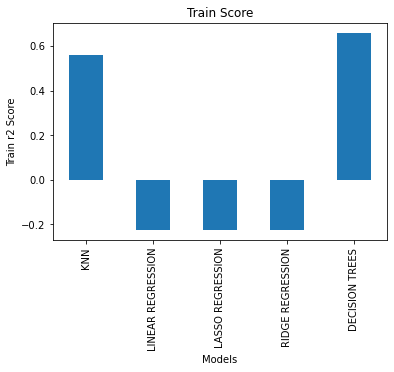

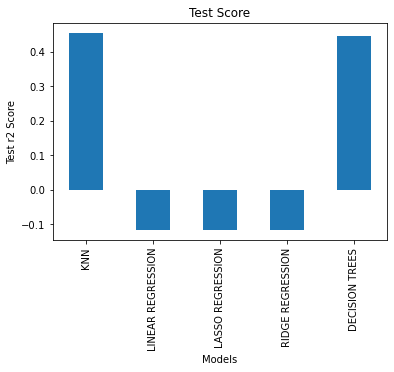

In [167]:
label = ['KNN', 'LINEAR REGRESSION', 'LASSO REGRESSION', 'RIDGE REGRESSION', 'DECISION TREES']
ax = comparison['Train_Score'].plot(kind='bar', title='Train Score')
ax.set_label(ax.containers[0])
ax.set_ylabel('Train r2 Score')
ax.set_xlabel('Models')
ax.set_xticklabels(label)
plt.show()
ax1 = comparison['Test_Score'].plot(kind='bar',title='Test Score')
ax1.set_label(ax1.containers[0])
ax1.set_ylabel('Test r2 Score')
ax1.set_xlabel('Models')
ax1.set_xticklabels(label)
plt.show()

In [168]:
### Based on the features that I have considered for models, Decision trees are best on training and testing data, followed by KNN
### More analysis can be conducted considering evolved features like average speed